# Import and Augment David's Data
The fly trajectory data from David's experiments lacks the necessary fields used in our estimator. In addition, the coordinate frame is the mirror-image of the coordinate frame we trained our estimator on, so this must also be taken into account. These problems, as well as more benign quality-of-life-changes, are made below. Note: this section needs only to be run once.

## Define Augmentation Function

In [16]:
import pynumdiff as pynd
import numpy as np
import pandas as pd

# augmentation function; copied from above for modularity in running sections
def augment_fly_trajectory(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
    # extract groundspeed and groundspeed angle
    augmented_trajectory = fly_trajectory_and_body.copy()
    gnd_velocity_x, gnd_velocity_y = augmented_trajectory["velocity_x"],augmented_trajectory["velocity_y"]
    augmented_trajectory["groundspeed"] = np.sqrt(gnd_velocity_x**2 + gnd_velocity_y**2)
    augmented_trajectory["groundspeed_angle"] = np.arctan2(gnd_velocity_y,gnd_velocity_x)

    # extract airspeed and airspeed angle
    airspeed_x, airspeed_y = augmented_trajectory["airvelocity_x"],augmented_trajectory["airvelocity_y"]
    augmented_trajectory["airspeed"] = np.sqrt(airspeed_x**2 + airspeed_y**2)
    augmented_trajectory["airspeed_angle"] = np.arctan2(airspeed_y,airspeed_x)
    
    # compute linear acceleration and linear acceleration angle
    params = [2, 10, 10]
    dt = np.median(np.diff(augmented_trajectory.timestamp))
    _, accel_x = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_x"], dt,params)
    _, accel_y = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_y"], dt,params)
    augmented_trajectory["linear_acceleration"] = np.sqrt(accel_x ** 2 + accel_y ** 2)
    augmented_trajectory["linear_acceleration_angle"] = np.arctan2(accel_y, accel_x) 

    # compute thrust and thrust angle
    mass=0.25e-6
    dragcoeff = mass / 0.170
    thrust_x = mass * accel_x + dragcoeff * airspeed_x
    thrust_y = mass * accel_y + dragcoeff * airspeed_y
    augmented_trajectory["thrust"] = np.sqrt(thrust_x ** 2 + thrust_y ** 2)
    augmented_trajectory["thrust_angle"] = np.arctan2(thrust_y, thrust_x)
    return augmented_trajectory

## Import David's Data and Make Minor Changes 

In [17]:
# import data and rename fields
temp_fly_data = pd.read_csv('../ExperimentalData/laminar_orco_flash.csv')
temp_fly_data.rename(columns={'obj_id':'trajec_objid','x': 'position_x','y': 'position_y','heading':'heading_angle',"xvel": "velocity_x","yvel": "velocity_y"},inplace=True)

# include only relevant fields
temp_fly_data = temp_fly_data[["trajec_objid", "timestamp", "position_x", "position_y", "velocity_x", "velocity_y","heading_angle"]]

# add necessary fields
temp_fly_data['windspeed'] = 0.4
temp_fly_data['windspeed_angle'] = -np.pi
temp_fly_data['airvelocity_x'] = temp_fly_data['velocity_x'] + 0.4
temp_fly_data['airvelocity_y'] = temp_fly_data['velocity_y'] 
temp_fly_data['heading_angle_x'] = np.cos(temp_fly_data['heading_angle']) 
temp_fly_data['heading_angle_y'] = np.sin(temp_fly_data['heading_angle']) 

# start each merged dataframe at 0, for consistency
def transform_timestamps_to_start_at_zero(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"] - fly_trajectory_and_body["timestamp"][0]
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"].round(2)
    return fly_trajectory_and_body

# Split the DataFrame into a list of DataFrames based on the 'key' column
temp_fly_data = [group for _, group in temp_fly_data.groupby('trajec_objid')]

# filter trajectories based on length
temp_fly_data = [trajectory for trajectory in temp_fly_data if len(trajectory) > 12]

## Call Augmentation Function and Write New Dataset

In [18]:
temp_fly_data = [augment_fly_trajectory(trajectory) for trajectory in temp_fly_data]
David_fly_data = pd.concat(temp_fly_data, ignore_index=True)
David_fly_data.to_csv((f'../ExperimentalData/david_data_augmented.csv'))

# Predict Headings for Augmented David's Data

## Import Augmented David's Data

In [19]:
David_fly_data = pd.read_csv(f'../ExperimentalData/david_data_augmented.csv')
body_and_trajectory_by_id = [group for _, group in David_fly_data.groupby('trajec_objid')]

## Define Prediction Function

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import fly_plot_lib_plot as fpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from keras.models import load_model
best_estimator = load_model('model.keras')

# Define a colormap with a single color
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_cmap', ['blue', 'blue'])
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_cmap', ['red', 'red'])

from scipy.ndimage import gaussian_filter1d

def plot_trajectory_with_predicted_heading(trajectory: pd.DataFrame, axis: plt.Axes,best_estimator, n_input: int=32,nskip: int=0,arrow_size=None,include_id=False,plt_show=False,smooth=False,**kwargs):
    def predict_heading_from_fly_trajectory(df: pd.DataFrame, n_input, augment_with_time_delay_embedding: callable, estimator: callable, **kwargs):
        augmented_df = augment_with_time_delay_embedding([df],**kwargs)
        augmented_df = augmented_df.iloc[:, 0:n_input]
        heading_components= estimator.predict(augmented_df)
        if smooth:
            # Gaussian smoothing parameters
            sigma = 2  # Standard deviation for the Gaussian filter, adjust as needed
            heading_components= gaussian_filter1d(estimator.predict(augmented_df),sigma=sigma,axis=0)
        heading_angle_predicted = np.arctan2(heading_components[:,1],heading_components[:,0])
        number_of_beginning_time_steps_deleted = len(df["position_x"]) - len(heading_angle_predicted) # obviously, this will not be the beginning time steps if you change the time augmentation to "forward"; similarly, a "center" time augmentation would delete things on both ends
        first_value = heading_angle_predicted[0]
        prepend_values = np.array([first_value] * number_of_beginning_time_steps_deleted)
        heading_angle_predicted_arr = np.concatenate([prepend_values, heading_angle_predicted])
        return heading_angle_predicted_arr
    
    def plot_trajectory(xpos, ypos, phi, color, ax=None, size_radius=None, nskip=0,
                colormap='bone_r', colornorm=None, edgecolor='none', reverse=False,alpha=0.7):
        if color is None:
                color = phi

        color = np.array(color)

            #Set size radius
        xymean = np.mean(np.abs(np.hstack((xpos, ypos))))
        if size_radius is None:  # auto set
            xymean = 0.21 * xymean
            if xymean < 0.0001:
                sz = np.array(0.01)
            else:
                sz = np.hstack((xymean, 1))
            size_radius = sz[sz > 0][0]
        else:
            if isinstance(size_radius, list):  # scale default by scalar in list
                xymean = size_radius[0] * xymean
                sz = np.hstack((xymean, 1))
                size_radius = sz[sz > 0][0]
            else:  # use directly
                size_radius = size_radius

        if colornorm is None:
            colornorm = [np.min(color), np.max(color)]

        if reverse:
            xpos = np.flip(xpos, axis=0)
            ypos = np.flip(ypos, axis=0)
            phi = np.flip(phi, axis=0)
            color = np.flip(color, axis=0)

        fpl.colorline_with_heading(ax, np.flip(xpos), np.flip(ypos), np.flip(color, axis=0), np.flip(phi),
                                    nskip=nskip,
                                    size_radius=size_radius,
                                    deg=False,
                                    colormap=colormap,
                                    center_point_size=0.0001,
                                    colornorm=colornorm,
                                    show_centers=False,
                                    size_angle=20,
                                    alpha=alpha,
                                    edgecolor=edgecolor)

        ax.set_aspect('equal')
        
        # Define fixed minimum plot size
        min_size = 0.1  # Adjust this value as needed

        xrange = xpos.max() - xpos.min()
        xrange = np.max([xrange, min_size])
        yrange = ypos.max() - ypos.min()
        yrange = np.max([yrange, min_size])

        ax.set_xlim(xpos.min() - 0.2 * xrange, xpos.max() + 0.2 * xrange)
        ax.set_ylim(ypos.min() - 0.2 * yrange, ypos.max() + 0.2 * yrange)

        if include_id:
            ax.set_title(trajectory['trajec_objid'].iloc[0])
    heading_angle_predicted = predict_heading_from_fly_trajectory(trajectory,n_input,augment_with_time_delay_embedding,best_estimator,**kwargs)

    # Plot the predicted heading trajectory first so that it is under the actual trajectory
    plot_trajectory(trajectory.position_x.values,
                    trajectory.position_y.values,
                    heading_angle_predicted, 
                    trajectory.timestamp.values,
                    ax=axis,
                    size_radius=arrow_size,
                    nskip=nskip,
                    colormap=blue_cmap,  
                    colornorm=None,
                    edgecolor='none',
                    reverse=False,
                    alpha=0.7) # Different shade for distinction
    
    # Plot actual trajectory
    plot_trajectory(trajectory.position_x.values,
                    trajectory.position_y.values,
                    trajectory.heading_angle.values,
                    trajectory.timestamp.values,
                    ax=axis,
                    size_radius=arrow_size,
                    nskip=nskip,
                    colormap=red_cmap,
                    colornorm=None,
                    edgecolor="black",
                    reverse=False,
                    alpha=0.3)
    
    return heading_angle_predicted

## Define Time-Delay Embedding Function

In [21]:
input_names = [
    'groundspeed',
    'groundspeed_angle',
    'windspeed',
     'windspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

output_names = ['heading_angle_x', 'heading_angle_y']

time_window = 4

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": input_names,
    "output_names": output_names,
    "direction": "backward"
}

In [22]:
def augment_with_time_delay_embedding(fly_traj_list: list[pd.DataFrame],**kwargs):
    def collect_offset_rows(df, aug_column_names=None, keep_column_names=None, w=1, direction='backward'):
        """ Takes a pandas data frame with n rows, list of columns names, and a window size w.
            Then creates an augmented data frame that collects prior or future rows (in window)
            and stacks them as new columns. The augmented data frame will be size (n - w - 1) as the first/last
            w rows do not have enough data before/after them.

            Inputs
                df: pandas data frame
                aug_column_names: names of the columns to augment
                keep_column_names: names of the columns to keep, but not augment
                w: lookback window size (# of rows)
                direction: get the rows from behind ('backward') or front ('forward')

            Outputs
                df_aug: augmented pandas data frame.
                        new columns are named: old_name_0, old_name_1, ... , old_name_w-1
        """

        df = df.reset_index(drop=True)

        # Default for testing
        if df is None:
            df = np.atleast_2d(np.arange(0, 11, 1, dtype=np.double)).T
            df = np.matlib.repmat(df, 1, 4)
            df = pd.DataFrame(df, columns=['a', 'b', 'c', 'd'])
            aug_column_names = ['a', 'b']
        else:  # use the input  values
            # Default is all columns
            if aug_column_names is None:
                aug_column_names = df.columns

        # Make new column names & dictionary to store data
        new_column_names = {}
        df_aug_dict = {}
        for a in aug_column_names:
            new_column_names[a] = []
            df_aug_dict[a] = []

        for a in aug_column_names:  # each augmented column
            for k in range(w):  # each point in lookback window
                new_column_names[a].append(a + '_' + str(k))

        # Augment data
        n_row = df.shape[0]  # # of rows
        n_row_train = n_row - w + 1  # # of rows in augmented data
        for a in aug_column_names:  # each column to augment
            data = df.loc[:, [a]]  # data to augment
            data = np.asmatrix(data)  # as numpy matrix
            df_aug_dict[a] = np.nan * np.ones((n_row_train, len(new_column_names[a])))  # new augmented data matrix

            # Put augmented data in new column, for each column to augment
            for i in range(len(new_column_names[a])):  # each column to augment
                if direction == 'backward':
                    # Start index, starts at the lookback window size & slides up by 1 for each point in window
                    startI = w - 1 - i

                    # End index, starts at end of the matrix &  & slides up by 1 for each point in window
                    endI = n_row - i  # end index, starts at end of matrix &

                elif direction == 'forward':
                    # Start index, starts at the beginning of matrix & slides up down by 1 for each point in window
                    startI = i

                    # End index, starts at end of the matrix minus the window size
                    # & slides down by 1 for each point in window
                    endI = n_row - w + 1 + i  # end index, starts at end of matrix &

                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                # Put augmented data in new column
                df_aug_dict[a][:, i] = np.squeeze(data[startI:endI, :])

            # Convert data to pandas data frame & set new column names
            df_aug_dict[a] = pd.DataFrame(df_aug_dict[a], columns=new_column_names[a])

        # Combine augmented column data
        df_aug = pd.concat(list(df_aug_dict.values()), axis=1)

        # Add non-augmented data, if specified
        if keep_column_names is not None:
            for c in keep_column_names:
                if direction == 'backward':
                    startI = w - 1
                    endI = n_row
                elif direction == 'forward':
                    startI = 0
                    endI = n_row - w
                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                keep = df.loc[startI:endI, [c]].reset_index(drop=True)
                df_aug = pd.concat([df_aug, keep], axis=1)

        return df_aug
    time_window = kwargs["time_window"]
    input_names = kwargs["input_names"]
    output_names = kwargs["output_names"]
    direction = kwargs["direction"]
    traj_augment_list = []
    for traj in fly_traj_list:
        traj_augment = collect_offset_rows(traj,
                                                aug_column_names=input_names,
                                                keep_column_names=output_names,
                                                w=time_window,
                                                direction=direction)

        traj_augment_list.append(traj_augment)

    traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

    return np.round(traj_augment_all, 4)

## Visualize Trajectory by ID

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step


array([-7.04489499e-02, -7.04489499e-02, -7.04489499e-02, -7.04489499e-02,
       -7.57126585e-02, -8.58171135e-02, -9.99471843e-02, -1.17049225e-01,
       -1.36050895e-01, -1.55952334e-01, -1.75752237e-01, -1.94353327e-01,
       -2.10504621e-01, -2.22798169e-01, -2.29888752e-01, -2.30994150e-01,
       -2.26335242e-01, -2.17063323e-01, -2.04637527e-01, -1.90004364e-01,
       -1.72948211e-01, -1.51930019e-01, -1.24309152e-01, -8.58334452e-02,
       -2.72310898e-02,  7.30259046e-02,  2.53096104e-01,  5.49209654e-01,
        9.31788921e-01,  1.27946711e+00,  1.51144874e+00,  1.63637567e+00,
        1.68728638e+00,  1.69312477e+00,  1.67793143e+00,  1.66247892e+00,
        1.66312528e+00,  1.68943119e+00,  1.74297583e+00,  1.81887090e+00,
        1.91053975e+00,  2.01714516e+00,  2.15164137e+00,  2.35116911e+00,
        2.70088339e+00, -2.95761824e+00, -2.25817776e+00, -1.83374727e+00,
       -1.61394179e+00, -1.50289488e+00, -1.46013653e+00, -1.46892893e+00,
       -1.51597941e+00, -

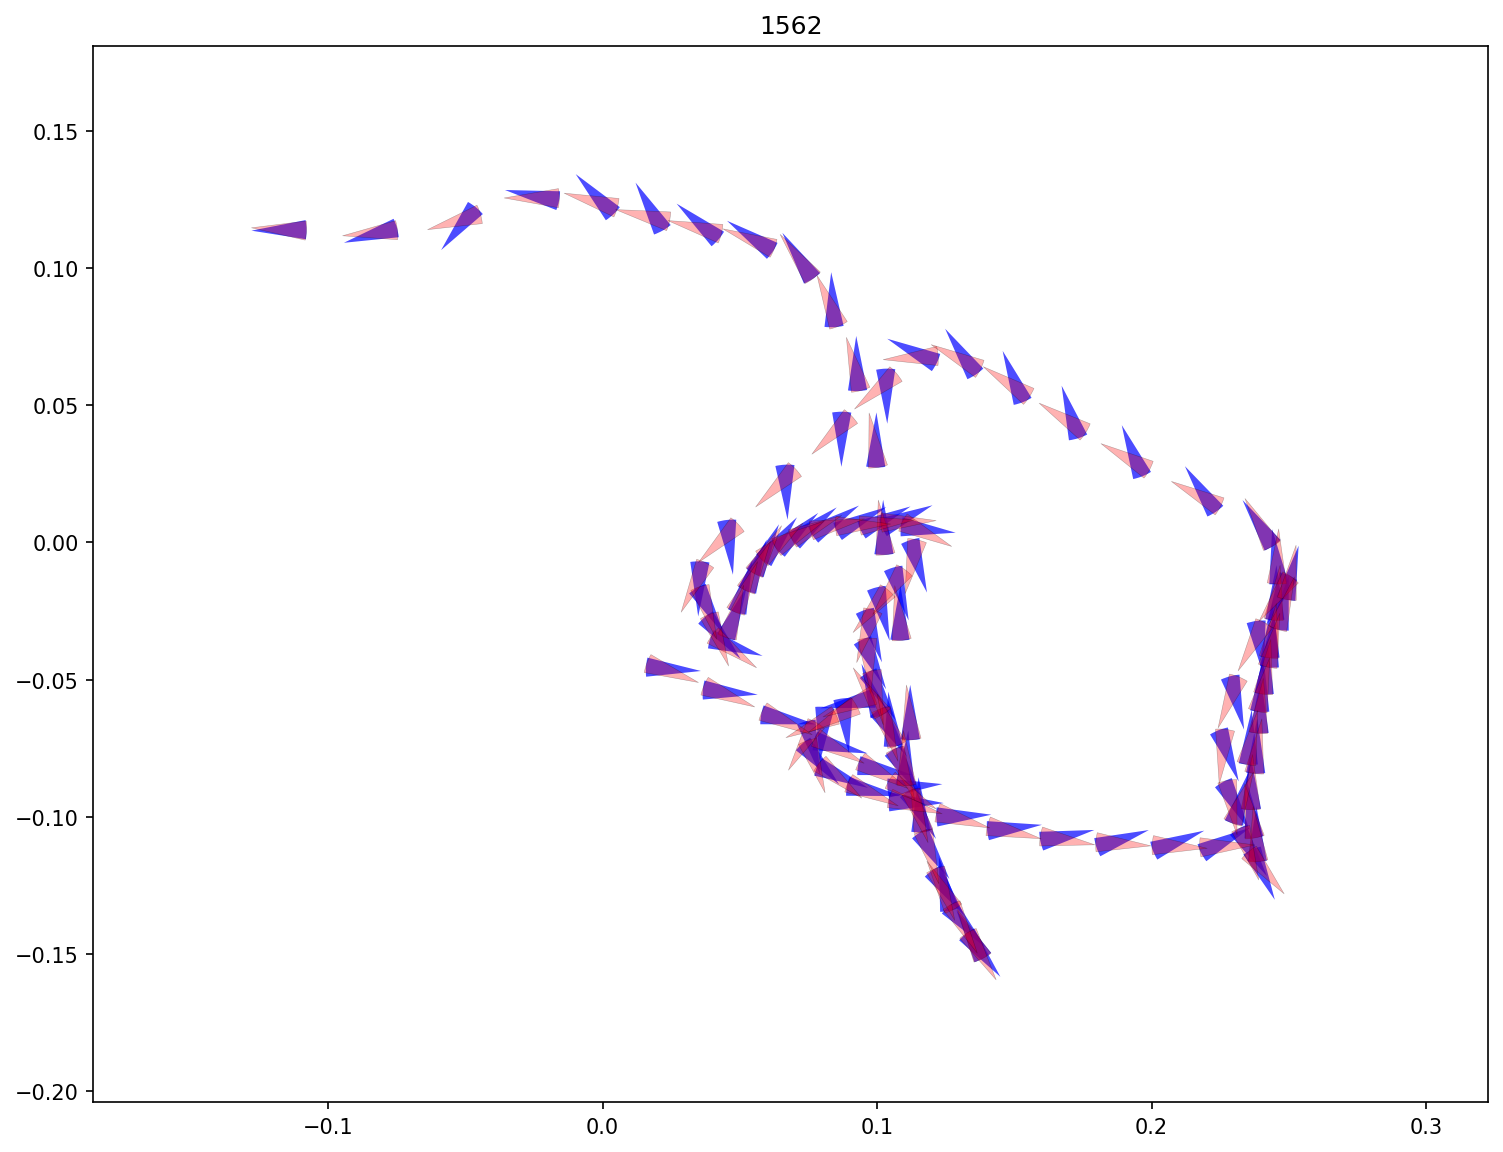

In [24]:
test_trajec_David = David_fly_data.loc[David_fly_data["trajec_objid"]==1562]
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
plot_trajectory_with_predicted_heading(test_trajec_David,ax,best_estimator,include_id=True,nskip=4,smooth=True,**time_augmentation_kwargs)

## Visualize ALL Trajectories

In [ ]:
import gc
# Loop through each trajectory and create/save figures
for trajectory in body_and_trajectory_by_id:
    trajec_objid = trajectory["trajec_objid"].iloc[0]
    fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
    plot_trajectory_with_predicted_heading(trajectory,ax,best_estimator,include_id=True,nskip=1,smooth=True,**time_augmentation_kwargs)
    
    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/neurel_net_david_data_svg/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')
    plt.close(fig)  # Close the figure to free up memory
    gc.collect()